In [22]:
import networkx as nx
import numpy as np
import torch_geometric
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 

import matplotlib.pyplot as plt
from tqdm import tqdm

from torch_geometric.data import Dataset, Data
from torch_geometric.loader.dataloader import DataLoader

from GraphDataset import RandomGraphDataset
from FullSimpleDataset import FullSimpleGraph
from GraphToSequence import graphToSequence, sequenceToGraph

from SimpleTransformer import Transformer
from lang import Lang

In [23]:
data_folder_training = "/eos/user/c/czeh/graphsequencer/fixed_edge_graph_training"
data_folder_test = "/eos/user/c/czeh/graphsequencer/fixed_edge_graph_test"


dataset_training = FullSimpleGraph(data_folder_training, nodes=5)
dataset_test = FullSimpleGraph(data_folder_test, nodes=5, test=True)

In [24]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [25]:
input_length = 10
max_seq_length = 10
max_edge_count = 6
batch_size = 1

In [26]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [28]:
# Generating data
converter = Lang(dataset_training.get(10).num_nodes+1)
vocab_size = converter.n_words

In [29]:
epochs = 200
d_model = 128
num_heads = 2
num_layers = 6
d_ff = 512
dropout = 0.1

# Model, loss, and optimizer
# model = SimpleTransformer(embed_size, input_length, vocab_size).to(device)
model = Transformer(dataset_training.get(10).num_nodes+1, vocab_size, d_model, num_heads, num_layers, d_ff, max_edge_count, max_seq_length, dropout).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Optionally introduce weight decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [30]:
losses_per_epoch = []
# Optionally introduce gradient clipping
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

#Initialize Variables for EarlyStopping
best_loss = float('inf')
best_model_weights = None
patience = 10

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    total_loss = 0
    for sample in tqdm(train_dl, desc="training"):
        sample_seq = sample[0].y
        
        input_tensor = torch.zeros((len(sample_seq)+1, input_length), dtype=torch.long).to(device)
        target_tensor = torch.zeros((len(sample_seq)+1, input_length), dtype=torch.long).to(device)
        edge_tensor = torch.zeros((len(sample_seq)+1, max_edge_count), dtype=torch.long).to(device)
        for i in range(len(sample_seq)+1):
            input_seq = converter.subseq2arr(sample_seq, input_length+1, max(i-input_length-1, 0), min(i+1, input_length+1))
            input_tensor[i, :] = torch.tensor(input_seq[:-1], dtype=torch.long)
            target_tensor[i, :] = torch.tensor(input_seq[1:], dtype=torch.long)
            edge_tensor[i, :] = torch.flatten(sample.edge_index.T).unsqueeze(0)
            
        optimizer.zero_grad()
        output = model(edge_tensor, input_tensor)
        loss = criterion(output.contiguous().view(-1, vocab_size), target_tensor.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    loss = total_loss / len(train_dl)
    print(f"Epoch {epoch+1}, Loss: {loss:.6f}")
    losses_per_epoch.append(loss)
        
    # Early stopping
    if loss < best_loss:
        best_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
        patience = 10  # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            break
            
# Load the best model weights
model.load_state_dict(best_model_weights)

training: 100%|██████████| 111/111 [00:06<00:00, 16.69it/s]


Epoch 1, Loss: 1.219792


training: 100%|██████████| 111/111 [00:05<00:00, 19.59it/s]


Epoch 2, Loss: 0.835437


training: 100%|██████████| 111/111 [00:06<00:00, 17.27it/s]


Epoch 3, Loss: 0.668069


training: 100%|██████████| 111/111 [00:05<00:00, 19.06it/s]


Epoch 4, Loss: 0.569048


training: 100%|██████████| 111/111 [00:05<00:00, 19.02it/s]


Epoch 5, Loss: 0.503412


training: 100%|██████████| 111/111 [00:06<00:00, 17.52it/s]


Epoch 6, Loss: 0.424398


training: 100%|██████████| 111/111 [00:05<00:00, 19.53it/s]


Epoch 7, Loss: 0.369134


training: 100%|██████████| 111/111 [00:06<00:00, 18.46it/s]


Epoch 8, Loss: 0.325514


training: 100%|██████████| 111/111 [00:05<00:00, 19.27it/s]


Epoch 9, Loss: 0.310579


training: 100%|██████████| 111/111 [00:06<00:00, 17.77it/s]


Epoch 10, Loss: 0.280390


training: 100%|██████████| 111/111 [00:06<00:00, 17.47it/s]


Epoch 11, Loss: 0.238086


training: 100%|██████████| 111/111 [00:06<00:00, 15.96it/s]


Epoch 12, Loss: 0.215471


training: 100%|██████████| 111/111 [00:06<00:00, 17.66it/s]


Epoch 13, Loss: 0.193867


training: 100%|██████████| 111/111 [00:06<00:00, 18.03it/s]


Epoch 14, Loss: 0.179786


training: 100%|██████████| 111/111 [00:05<00:00, 18.62it/s]


Epoch 15, Loss: 0.165531


training: 100%|██████████| 111/111 [00:06<00:00, 16.97it/s]


Epoch 16, Loss: 0.145217


training: 100%|██████████| 111/111 [00:06<00:00, 17.39it/s]


Epoch 17, Loss: 0.119940


training: 100%|██████████| 111/111 [00:06<00:00, 17.84it/s]


Epoch 18, Loss: 0.111028


training: 100%|██████████| 111/111 [00:06<00:00, 15.94it/s]


Epoch 19, Loss: 0.097513


training: 100%|██████████| 111/111 [00:06<00:00, 18.05it/s]


Epoch 20, Loss: 0.111706


training: 100%|██████████| 111/111 [00:05<00:00, 18.63it/s]


Epoch 21, Loss: 0.084344


training: 100%|██████████| 111/111 [00:06<00:00, 16.32it/s]


Epoch 22, Loss: 0.085689


training: 100%|██████████| 111/111 [00:05<00:00, 18.78it/s]


Epoch 23, Loss: 0.069800


training: 100%|██████████| 111/111 [00:06<00:00, 18.05it/s]


Epoch 24, Loss: 0.062237


training: 100%|██████████| 111/111 [00:06<00:00, 17.01it/s]


Epoch 25, Loss: 0.076501


training: 100%|██████████| 111/111 [00:06<00:00, 16.59it/s]


Epoch 26, Loss: 0.060342


training: 100%|██████████| 111/111 [00:06<00:00, 16.48it/s]


Epoch 27, Loss: 0.044688


training: 100%|██████████| 111/111 [00:06<00:00, 17.19it/s]


Epoch 28, Loss: 0.047335


training: 100%|██████████| 111/111 [00:06<00:00, 16.07it/s]


Epoch 29, Loss: 0.045875


training: 100%|██████████| 111/111 [00:06<00:00, 17.14it/s]


Epoch 30, Loss: 0.050296


training: 100%|██████████| 111/111 [00:06<00:00, 16.98it/s]


Epoch 31, Loss: 0.038728


training: 100%|██████████| 111/111 [00:05<00:00, 18.57it/s]


Epoch 32, Loss: 0.030759


training: 100%|██████████| 111/111 [00:06<00:00, 18.22it/s]


Epoch 33, Loss: 0.038808


training: 100%|██████████| 111/111 [00:06<00:00, 18.12it/s]


Epoch 34, Loss: 0.041929


training: 100%|██████████| 111/111 [00:06<00:00, 17.82it/s]


Epoch 35, Loss: 0.026662


training: 100%|██████████| 111/111 [00:06<00:00, 18.19it/s]


Epoch 36, Loss: 0.022323


training: 100%|██████████| 111/111 [00:06<00:00, 16.69it/s]


Epoch 37, Loss: 0.035224


training: 100%|██████████| 111/111 [00:06<00:00, 17.92it/s]


Epoch 38, Loss: 0.035133


training: 100%|██████████| 111/111 [00:06<00:00, 16.40it/s]


Epoch 39, Loss: 0.021202


training: 100%|██████████| 111/111 [00:06<00:00, 17.33it/s]


Epoch 40, Loss: 0.030243


training:  79%|███████▉  | 88/111 [00:05<00:01, 15.40it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Training Loss')

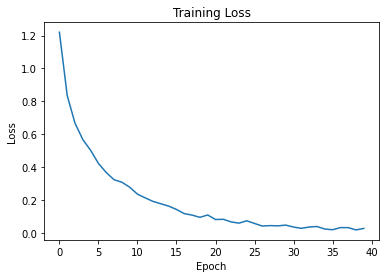

In [31]:
plt.plot(losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

test:  11%|█         | 1/9 [00:00<00:03,  2.16it/s]

Input Sequence: 1.(2.4.*1.);, tensor([[1, 1, 2],
        [2, 4, 4]])
Predicted Sequence: (2.4.*1.)<EOS>
Correct: False
incorrect sequence


test:  22%|██▏       | 2/9 [00:00<00:03,  2.24it/s]

Input Sequence: 2.3.(4.)(5.);, tensor([[2, 3, 3],
        [3, 4, 5]])
Predicted Sequence: 2.3.4.5.;<EOS>
Correct: False


test:  33%|███▎      | 3/9 [00:01<00:02,  2.32it/s]

Input Sequence: 3.1.2.4.;, tensor([[1, 1, 2],
        [2, 3, 4]])
Predicted Sequence: 3.2.1.4.;<EOS>
Correct: False
Input Sequence: 2.1.3.;4.5.;, tensor([[1, 1, 4],
        [2, 3, 5]])
Predicted Sequence: 1.3.;4.5.<EOS>
Correct: False


test:  56%|█████▌    | 5/9 [00:02<00:02,  1.87it/s]

Input Sequence: 2.3.5.4.;, tensor([[2, 3, 4],
        [3, 5, 5]])
Predicted Sequence: 2.3.5.4.;<EOS>
Correct: False


test:  67%|██████▋   | 6/9 [00:03<00:01,  1.88it/s]

Input Sequence: 2.1.(3.)(5.);, tensor([[1, 1, 1],
        [2, 3, 5]])
Predicted Sequence: .(3.)(5.)<EOS>
Correct: False


test:  78%|███████▊  | 7/9 [00:03<00:01,  1.91it/s]

Input Sequence: 1.2.;4.3.5.;, tensor([[1, 3, 3],
        [2, 4, 5]])
Predicted Sequence: 2.;3.5.4.<EOS>
Correct: False


test:  89%|████████▉ | 8/9 [00:04<00:00,  1.97it/s]

Input Sequence: 1.2.5.3.;, tensor([[1, 2, 3],
        [2, 5, 5]])
Predicted Sequence: 1.2.5.3.;<EOS>
Correct: False


test: 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]

Input Sequence: 1.5.2.3.;, tensor([[1, 2, 2],
        [5, 3, 5]])
Predicted Sequence: 1.5.2.3.;<EOS>
Correct: False
Percentage of correct guesses: 0.0


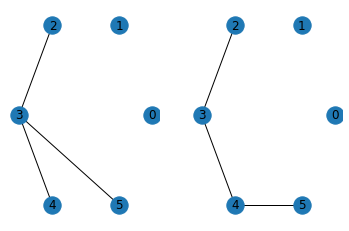

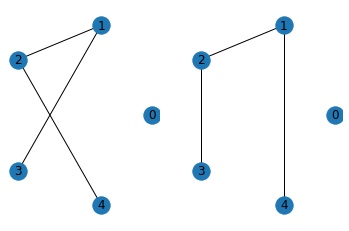

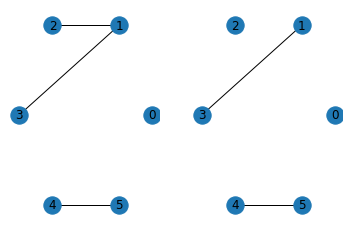

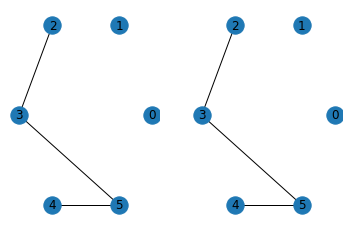

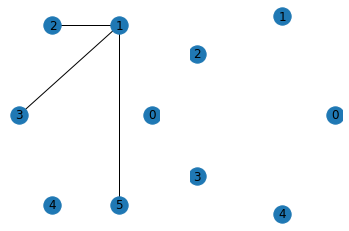

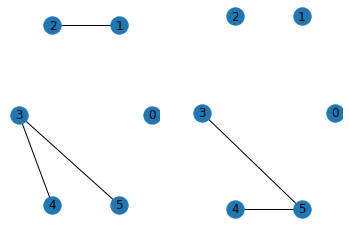

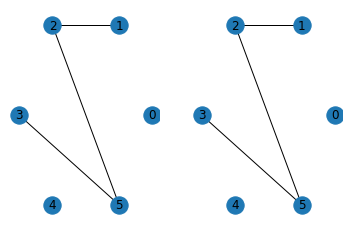

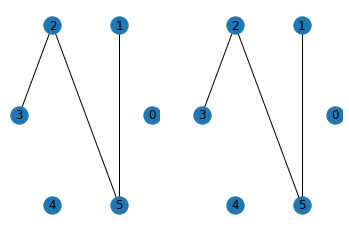

In [32]:
correct = 0
model.eval() 
torch.no_grad()
for sample in tqdm(test_dl, desc="test"):
    
    input_tensor = torch.tensor(converter.subseq2arr(sample.y, input_length, 0, 0)).unsqueeze(0).to(device)
    edge_tensor = torch.flatten(sample.edge_index.T).unsqueeze(0).to(device)
    
    predictions = model(edge_tensor, input_tensor)
    predicted_index = predictions.argmax(-1)
    predicted_number = predicted_index[0, -1].item()

    step = 0
    while (predicted_number != 2 and step < 15):  # Disable gradient computation for inference
        input_tensor = torch.roll(input_tensor, -1, dims=1)
        input_tensor[0, -1] = predicted_number
    
        predictions = model(edge_tensor, input_tensor)
        predicted_index = predictions.argmax(-1)  # Get the index of the max log-probability for the last position
        predicted_number = predicted_index[0, -1].item()  # Convert to Python number
        step += 1
     
    input_tensor = torch.roll(input_tensor, -1, dims=1)
    input_tensor[0, -1] = predicted_number 
    check = converter.arr2seq(input_tensor[0]) == converter.arr2seq(converter.subseq2arr(sample[0].y, input_length, 0, input_length))
    
    print(f"Input Sequence: {sample[0].y}, {sample.edge_index}")
    print(f"Predicted Sequence: {converter.arr2seq(input_tensor[0])}")
    print(f"Correct: {check}")
    
    try:
        origG = torch_geometric.utils.to_networkx(sample, to_undirected=True)
        res_nodes, res_edges = sequenceToGraph(converter.arr2seq(input_tensor[0], ignoreTokens=True))
        newData = Data(x=sample.x, num_nodes=sample.num_nodes, edge_index=torch.from_numpy(res_edges))
        G = torch_geometric.utils.to_networkx(newData, to_undirected=True)

        fig, ax = plt.subplots(1, 2)
        nx.draw_circular(origG, with_labels=True, ax=ax[0])
        nx.draw_circular(G, with_labels=True, ax=ax[1])
    except:
        print("incorrect sequence")
    
    
    correct += check

print(f"Percentage of correct guesses: {correct / (len(test_dl))}")